In [1]:
import os
from pathlib import Path
import ngauge
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict, deque, Counter
from brainlit.map_neurons.utils import replace_root, ZerothFirstOrderNeuron
from scipy.interpolate import splprep, splev
from similaritymeasures import frechet_dist
from brainlit.map_neurons.map_neurons import (
    Diffeomorphism_Transform,
)
import pickle
from tqdm import tqdm
import pandas as pd

In [2]:
swc_dir = (
    "/Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/mouselight-swcs/swcs-1"
)
swc_dir = Path(swc_dir)


swc_files = os.listdir(swc_dir)
swc_files = [swc_dir / f for f in swc_files if ".swc" in f]

In [3]:
def check_duplicates_center(neuron):
    assert len(neuron.branches) == 1

    stack = []
    stack += neuron.branches[0]
    coords = []

    while len(stack) > 0:
        child = stack.pop()
        stack += child.children
        coords.append([child.x, child.y, child.z])

    # look for duplicates
    dupes = []
    seen = set()
    for coord in coords:
        coord = tuple(coord)
        if coord in seen:
            dupes.append(coord)
        else:
            seen.add(coord)

    # center coordinates
    if len(dupes) > 0:
        raise ValueError(f"Duplicate nodes")
    else:
        coords = np.array(coords)
        mx = np.amax(coords, axis=0)
        mn = np.amin(coords, axis=0)
        center = np.mean(np.array([mx, mn]), axis=0)
        stack = [neuron.branches[0]]

        while len(stack) > 0:
            child = stack.pop()
            stack += child.children

            child.x -= center[0]
            child.y -= center[1]
            child.z -= center[2]

    return neuron

In [9]:
def compute_error(node, da, plot=False):
    parent = node.parent
    c = node.children[0]

    parent1 = ngauge.TracingPoint(
        x=float(parent.x), y=float(parent.y), z=float(parent.z), r=parent.r, t=parent.t
    )
    middle = ngauge.TracingPoint(
        x=float(node.x),
        y=float(node.y),
        z=float(node.z),
        r=node.r,
        t=node.t,
        parent=parent1,
    )
    parent1.children = [middle]
    child1 = ngauge.TracingPoint(
        x=float(c.x), y=float(c.y), z=float(c.z), r=c.r, t=c.t, parent=middle
    )
    middle.children = [child1]

    parent2 = ngauge.TracingPoint(
        x=float(parent.x), y=float(parent.y), z=float(parent.z), r=parent.r, t=parent.t
    )
    child2 = ngauge.TracingPoint(
        x=float(c.x), y=float(c.y), z=float(c.z), r=c.r, t=c.t, parent=parent2
    )
    parent2.children = [child2]

    neuron1 = ngauge.Neuron()
    neuron1.branches = [parent1]

    neuron2 = ngauge.Neuron()
    neuron2.branches = [parent2]

    zfon1 = ZerothFirstOrderNeuron(neuron=neuron1, da=da, sampling=0.5)
    zfon2 = ZerothFirstOrderNeuron(neuron=neuron2, da=da, sampling=0.5)

    DG1 = zfon1.DG
    DG2 = zfon2.DG
    assert len(DG1.nodes) == 1
    assert len(DG2.nodes) == 1

    root_0, root_1 = zfon1.make_path_pts(0)
    tck, u = DG1.nodes[0]["gt"]
    coords = splev(u, tck)
    gt_coords = np.stack(coords, axis=1)

    root_0, root_1 = zfon2.make_path_pts(0)

    first_coords = []
    stack = []
    stack += root_1
    while stack:
        child = stack.pop()
        stack += child.children
        first_coords.append([child.x, child.y, child.z])

    first_coords = np.array(first_coords)

    if plot:
        fig = plt.figure(figsize=(20, 10), dpi=300)
        ax0 = fig.add_subplot(1, 2, 1, projection="3d")
        a = np.array([parent1.x, parent1.y, parent1.z])
        b = np.array([middle.x, middle.y, middle.z])
        c = np.array([child1.x, child1.y, child1.z])
        print([np.linalg.norm(a - b), np.linalg.norm(b - c), np.linalg.norm(a - c)])
        ax0.plot(
            [parent2.x, child2.x],
            [parent2.y, child2.y],
            [parent2.z, child2.z],
            c="g",
            label="Middle Node Removed",
        )
        ax0.plot(
            [parent1.x, middle.x, child1.x],
            [parent1.y, middle.y, child1.y],
            [parent1.z, middle.z, child1.z],
            c="r",
            label="Original Segment",
        )
        ax0.scatter(
            [parent2.x, child2.x], [parent2.y, child2.y], [parent2.z, child2.z], c="g"
        )
        ax0.scatter(
            [parent1.x, middle.x, child1.x],
            [parent1.y, middle.y, child1.y],
            [parent1.z, middle.z, child1.z],
            c="r",
        )
        ax1 = fig.add_subplot(1, 2, 2, projection="3d")
        ax1.plot(
            first_coords[:, 0],
            first_coords[:, 1],
            first_coords[:, 2],
            c="g",
            label="1st Order Mapping of Middle Node Removed",
        )
        ax1.plot(
            gt_coords[:, 0],
            gt_coords[:, 1],
            gt_coords[:, 2],
            c="r",
            label="Ground Truth of Original Segment",
        )

        xmin, xmax = ax0.get_xlim()
        ymin, ymax = ax0.get_ylim()
        zmin, zmax = ax0.get_zlim()
        xs = np.arange(xmin, xmax, (xmax - xmin) / 4)
        ys = np.arange(ymin, ymax, (ymax - ymin) / 4)
        zs = np.arange(zmin, zmax, (zmax - zmin) / 4)

        og_coords = np.meshgrid(xs, ys, zs, indexing="ij")
        og_coords = np.array(
            [og_coords[0].flatten(), og_coords[1].flatten(), og_coords[2].flatten()]
        ).T
        new_coords = da.evaluate(og_coords)

        ax0.quiver(
            og_coords[:, 0],
            og_coords[:, 1],
            og_coords[:, 2],
            new_coords[:, 0] - og_coords[:, 0],
            new_coords[:, 1] - og_coords[:, 1],
            new_coords[:, 2] - og_coords[:, 2],
            length=0.05,
            label="Scaled Displacement Field",
            # alpha=0.5,
        )

        plt.rcParams.update({"font.size": 22})

        ax0.legend(fontsize=16)
        ax1.legend(fontsize=16)
        fig.tight_layout()

    ds_first_error = frechet_dist(gt_coords, first_coords)

    return ds_first_error

In [12]:
def compute_dist(neuron, da):
    def node_dist(i, j):
        p = i.parent
        c = i.children[j]
        s1 = np.linalg.norm(np.subtract([p.x, p.y, p.z], [i.x, i.y, i.z]))
        s2 = np.linalg.norm(np.subtract([c.x, c.y, c.z], [i.x, i.y, i.z]))
        s3 = np.linalg.norm(np.subtract([c.x, c.y, c.z], [p.x, p.y, p.z]))
        theta = np.arccos((s1**2 + s3**2 - s2**2) / (2 * s1 * s3))
        dist = np.sin(theta) * s1
        return dist, s3

    q = deque(neuron)
    p = deque()
    projection_dists = []
    total = 0

    while q:
        i = q.pop()
        p.extend(i)
    while p:
        total += 1
        i = p.pop()
        if len(i.children) > 1:
            for j in range(len(i.children)):
                dist, s3 = node_dist(i, j)
                projection_dists.append(dist)
                p.append(i.children[j])
        elif i.children:
            angle = i.angle(i.parent, i.children[0])
            if angle > 170:
                error = compute_error(i, da, plot=False)
                # plt.show()
                # raise ValueError()
                projection_dists.append(error)

            p.append(i.children[0])

    return projection_dists, total

In [13]:
rates = []
sigmas = []

for sigma in [40, 80, 160, 320]:
    transform_fname = swc_dir.parents[0] / f"exp-morpho-diffeo-{sigma}.pickle"

    with open(transform_fname, "rb") as handle:
        transform_data = pickle.load(handle)
        xv = transform_data["xv"]
        phii = transform_data["phii"]

    ct = Diffeomorphism_Transform(xv, phii)

    for swc_file in swc_files:
        neuron = ngauge.Neuron.from_swc(swc_file)
        neuron = replace_root(neuron)
        neuron = check_duplicates_center(neuron)

        projection_dists, total = compute_dist(neuron, da=ct)
        projection_dists = np.array(projection_dists)

        small_count = np.sum(projection_dists <= 1)

        rates.append(small_count / total * 100)
        sigmas.append(sigma)
        print(f"{small_count} out of {total} = {small_count/total*100}%")

data = {"Nodes with Submicron Error (%)": rates, "Sigma": sigmas}

201 out of 6148 = 3.2693558880936893%
613 out of 4250 = 14.423529411764708%
39 out of 1180 = 3.305084745762712%
12 out of 756 = 1.5873015873015872%
15 out of 759 = 1.9762845849802373%
40 out of 923 = 4.333694474539545%
31 out of 1358 = 2.2827687776141383%
156 out of 3605 = 4.327323162274618%
153 out of 3963 = 3.860711582134747%
1039 out of 5692 = 18.2536893886156%
225 out of 17361 = 1.2960082944530846%
1746 out of 11074 = 15.766660646559508%
1426 out of 19899 = 7.166189255741495%
932 out of 6886 = 13.534708103398199%
336 out of 4462 = 7.530255490811295%
2598 out of 35158 = 7.389498833835827%
146 out of 1580 = 9.240506329113925%
776 out of 5224 = 14.854517611026033%
93 out of 3215 = 2.892690513219285%
663 out of 5780 = 11.470588235294118%
204 out of 6148 = 3.318152244632401%
602 out of 4250 = 14.16470588235294%
33 out of 1180 = 2.7966101694915255%
9 out of 756 = 1.1904761904761905%
15 out of 759 = 1.9762845849802373%
35 out of 923 = 3.791982665222102%
31 out of 1358 = 2.2827687776141383

In [18]:
pct_fname = swc_dir.parents[0] / f"pct-submicron.pickle"
if os.path.exists(pct_fname):
    with open(pct_fname, "rb") as handle:
        data = pickle.load(handle)
else:
    with open(pct_fname, "wb") as handle:
        pickle.dump(data, handle)

data["Sigma"] = [i * 2 for i in data["Sigma"]]
df = pd.DataFrame(data)

<Axes: xlabel='Sigma', ylabel='Nodes with Submicron Error (%)'>

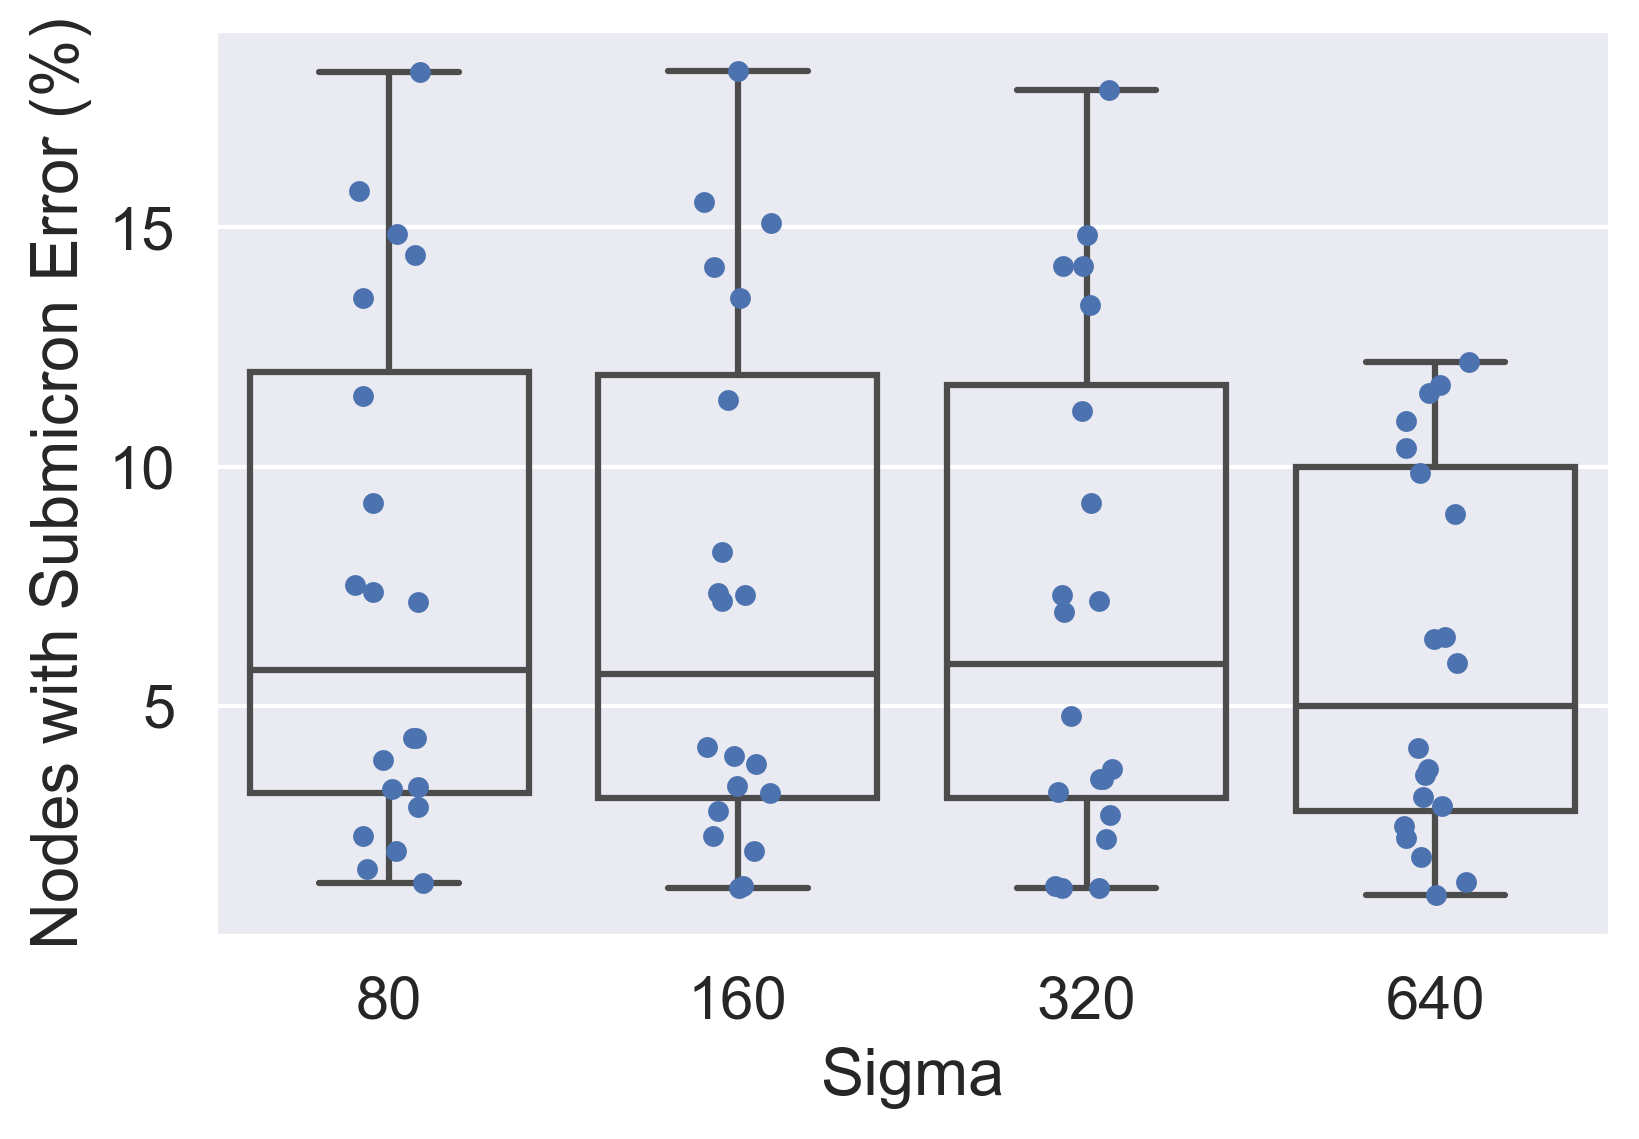

In [19]:
f, ax = plt.subplots(1, 1, dpi=300)

PROPS = {
    "boxprops": {"facecolor": "none"},
}

sns.set(font_scale=1.3)
sns.boxplot(data=df, x="Sigma", y="Nodes with Submicron Error (%)", **PROPS)
sns.stripplot(data=df, x="Sigma", y="Nodes with Submicron Error (%)")